In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from notebooks.utils import display, sample_batch

In [4]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 100 # 훈련이 오래 걸려 에포크 횟수를 300에서 100으로 줄입니다.
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

In [6]:
train_data = utils.image_dataset_from_directory(
    "./datasets/dataset",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40000 files belonging to 1 classes.


In [9]:
def preprocess(img):
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

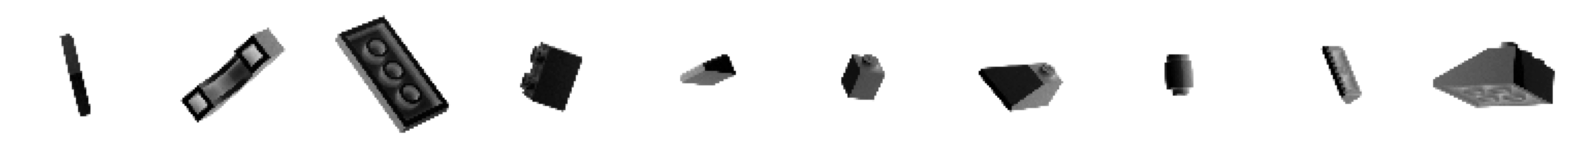

In [11]:
train_sample = sample_batch(train)
display(train_sample)

In [12]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1024      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131072    
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0     

In [13]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 100)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 512)         819200    
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         2097152   
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 256)         1024

In [14]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # 잠재 공간에서 랜덤 포인트 샘플링
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # 가짜 이미지로 판별자 훈련하기
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # 메트릭 업데이트
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [15]:
# DCGAN 생성
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [16]:
if LOAD_MODEL:
    dcgan.load_weights("./checkpoint/checkpoint.ckpt")

In [17]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [18]:
# Make model checkpoints
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0: # 출력 횟수를 줄이기 위해
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images * 127.5 + 127.5
            generated_images = generated_images.numpy()
            display(
                generated_images,
                save_to="./output/generated_img_%03d.png" % (epoch),
            )

Epoch 1/100
313/313 [==============================] - 51s 161ms/step - d_loss: -0.0090 - d_real_acc: 0.9068 - d_fake_acc: 0.9205 - d_acc: 0.9137 - g_loss: 5.1662 - g_acc: 0.0795

Saved to ./output/generated_img_000.png


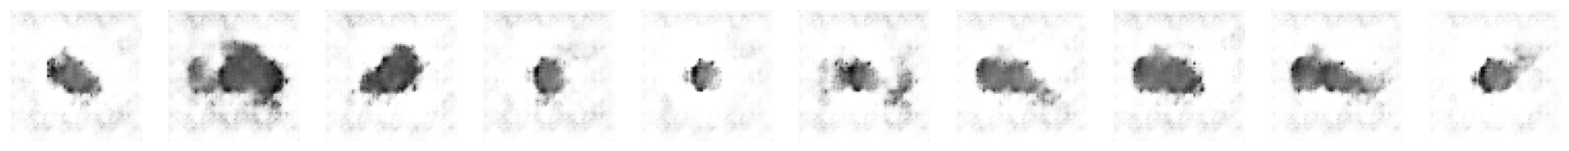

Epoch 2/100
313/313 [==============================] - 55s 174ms/step - d_loss: 0.0361 - d_real_acc: 0.8941 - d_fake_acc: 0.8989 - d_acc: 0.8965 - g_loss: 5.7300 - g_acc: 0.1010
Epoch 3/100
313/313 [==============================] - 51s 162ms/step - d_loss: 0.1251 - d_real_acc: 0.8803 - d_fake_acc: 0.8795 - d_acc: 0.8799 - g_loss: 4.6770 - g_acc: 0.1205
Epoch 4/100
313/313 [==============================] - 51s 163ms/step - d_loss: 0.0857 - d_real_acc: 0.8899 - d_fake_acc: 0.8889 - d_acc: 0.8895 - g_loss: 4.6456 - g_acc: 0.1111
Epoch 5/100
313/313 [==============================] - 51s 162ms/step - d_loss: 0.1287 - d_real_acc: 0.8749 - d_fake_acc: 0.8787 - d_acc: 0.8768 - g_loss: 4.2905 - g_acc: 0.1213
Epoch 6/100
313/313 [==============================] - 50s 159ms/step - d_loss: 0.0946 - d_real_acc: 0.8916 - d_fake_acc: 0.8895 - d_acc: 0.8905 - g_loss: 4.4099 - g_acc: 0.1106
Epoch 7/100
313/313 [==============================] - 50s 158ms/step - d_loss: 0.0796 - d_real_acc: 0.8934 - 

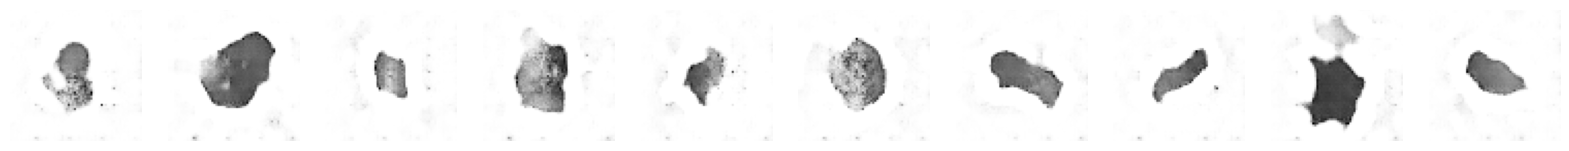

Epoch 12/100
313/313 [==============================] - 49s 155ms/step - d_loss: -0.0093 - d_real_acc: 0.9199 - d_fake_acc: 0.9216 - d_acc: 0.9208 - g_loss: 5.4522 - g_acc: 0.0784
Epoch 13/100
313/313 [==============================] - 49s 156ms/step - d_loss: 0.0175 - d_real_acc: 0.9157 - d_fake_acc: 0.9187 - d_acc: 0.9172 - g_loss: 5.4389 - g_acc: 0.0813
Epoch 14/100
313/313 [==============================] - 49s 156ms/step - d_loss: 0.0089 - d_real_acc: 0.9107 - d_fake_acc: 0.9121 - d_acc: 0.9114 - g_loss: 5.7189 - g_acc: 0.0879
Epoch 15/100
313/313 [==============================] - 49s 156ms/step - d_loss: -0.0250 - d_real_acc: 0.9270 - d_fake_acc: 0.9271 - d_acc: 0.9270 - g_loss: 6.2071 - g_acc: 0.0729
Epoch 16/100
313/313 [==============================] - 51s 163ms/step - d_loss: -0.0391 - d_real_acc: 0.9296 - d_fake_acc: 0.9308 - d_acc: 0.9302 - g_loss: 5.6746 - g_acc: 0.0692
Epoch 17/100
313/313 [==============================] - 51s 161ms/step - d_loss: 0.0365 - d_real_acc: 

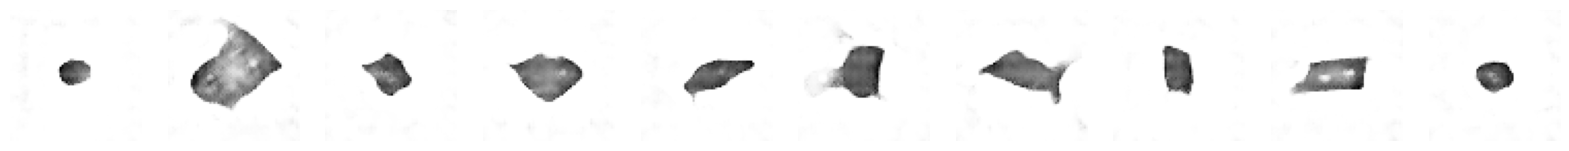

Epoch 22/100
313/313 [==============================] - 51s 163ms/step - d_loss: -0.0030 - d_real_acc: 0.9135 - d_fake_acc: 0.9122 - d_acc: 0.9129 - g_loss: 6.3206 - g_acc: 0.0878
Epoch 23/100
313/313 [==============================] - 52s 165ms/step - d_loss: -0.1268 - d_real_acc: 0.9423 - d_fake_acc: 0.9431 - d_acc: 0.9427 - g_loss: 7.3981 - g_acc: 0.0569
Epoch 24/100
313/313 [==============================] - 51s 162ms/step - d_loss: -0.0691 - d_real_acc: 0.9286 - d_fake_acc: 0.9298 - d_acc: 0.9292 - g_loss: 6.7130 - g_acc: 0.0702
Epoch 25/100
313/313 [==============================] - 51s 164ms/step - d_loss: -0.0977 - d_real_acc: 0.9322 - d_fake_acc: 0.9333 - d_acc: 0.9328 - g_loss: 7.3847 - g_acc: 0.0667
Epoch 26/100
313/313 [==============================] - 51s 161ms/step - d_loss: -0.1068 - d_real_acc: 0.9396 - d_fake_acc: 0.9408 - d_acc: 0.9402 - g_loss: 7.7625 - g_acc: 0.0593
Epoch 27/100
313/313 [==============================] - 52s 164ms/step - d_loss: -0.1617 - d_real_ac

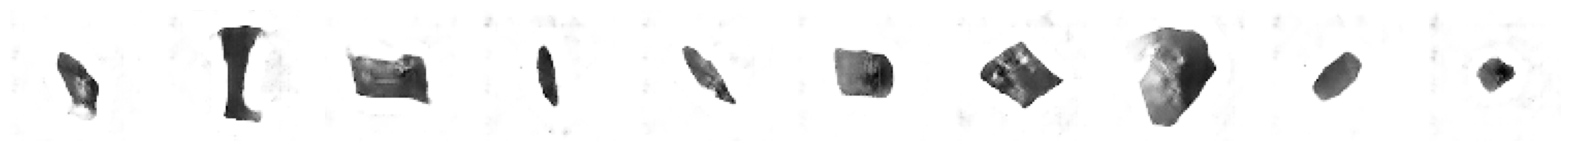

Epoch 32/100
313/313 [==============================] - 50s 159ms/step - d_loss: -0.1121 - d_real_acc: 0.9315 - d_fake_acc: 0.9340 - d_acc: 0.9327 - g_loss: 7.7841 - g_acc: 0.0660
Epoch 33/100
313/313 [==============================] - 50s 158ms/step - d_loss: -0.1897 - d_real_acc: 0.9500 - d_fake_acc: 0.9507 - d_acc: 0.9503 - g_loss: 8.4997 - g_acc: 0.0493
Epoch 34/100
313/313 [==============================] - 49s 156ms/step - d_loss: 0.0755 - d_real_acc: 0.9089 - d_fake_acc: 0.9189 - d_acc: 0.9139 - g_loss: 7.3116 - g_acc: 0.0811
Epoch 35/100
313/313 [==============================] - 49s 156ms/step - d_loss: -0.0966 - d_real_acc: 0.9337 - d_fake_acc: 0.9375 - d_acc: 0.9356 - g_loss: 7.9984 - g_acc: 0.0625
Epoch 36/100
313/313 [==============================] - 49s 156ms/step - d_loss: -0.1576 - d_real_acc: 0.9405 - d_fake_acc: 0.9436 - d_acc: 0.9420 - g_loss: 8.2870 - g_acc: 0.0564
Epoch 37/100
313/313 [==============================] - 49s 156ms/step - d_loss: -0.2779 - d_real_acc

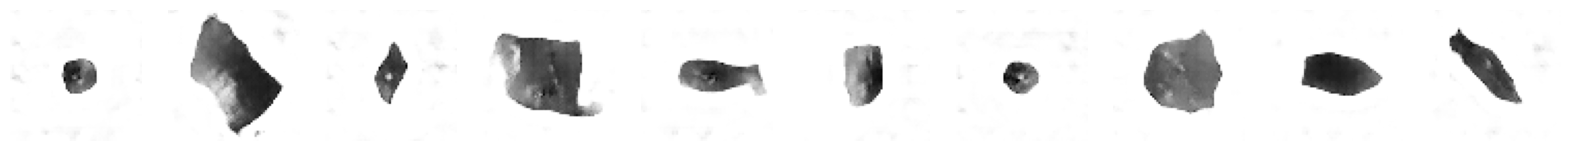

Epoch 42/100
313/313 [==============================] - 50s 159ms/step - d_loss: -0.0955 - d_real_acc: 0.9340 - d_fake_acc: 0.9392 - d_acc: 0.9366 - g_loss: 8.4093 - g_acc: 0.0608
Epoch 43/100
313/313 [==============================] - 49s 156ms/step - d_loss: -0.4127 - d_real_acc: 0.9703 - d_fake_acc: 0.9711 - d_acc: 0.9707 - g_loss: 10.7005 - g_acc: 0.0289
Epoch 44/100
313/313 [==============================] - 49s 156ms/step - d_loss: -0.2182 - d_real_acc: 0.9468 - d_fake_acc: 0.9525 - d_acc: 0.9496 - g_loss: 9.4064 - g_acc: 0.0475
Epoch 45/100
313/313 [==============================] - 49s 155ms/step - d_loss: 2.3453 - d_real_acc: 0.9324 - d_fake_acc: 0.6251 - d_acc: 0.7787 - g_loss: 6.7380 - g_acc: 0.3749
Epoch 46/100
313/313 [==============================] - 49s 156ms/step - d_loss: 0.0512 - d_real_acc: 0.9008 - d_fake_acc: 0.9031 - d_acc: 0.9020 - g_loss: 7.2497 - g_acc: 0.0969
Epoch 47/100
313/313 [==============================] - 49s 157ms/step - d_loss: -0.3137 - d_real_acc

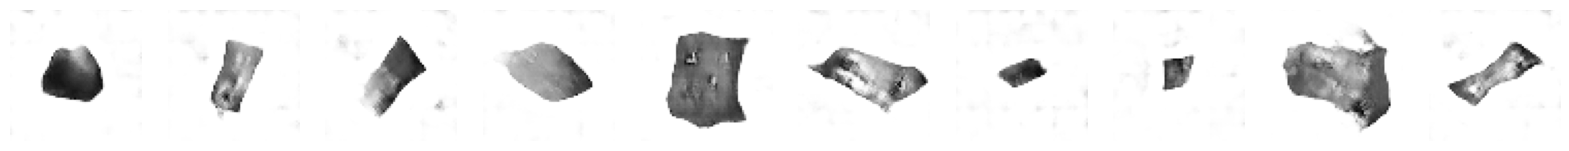

Epoch 52/100
313/313 [==============================] - 52s 164ms/step - d_loss: -0.2869 - d_real_acc: 0.9533 - d_fake_acc: 0.9579 - d_acc: 0.9556 - g_loss: 9.9797 - g_acc: 0.0421
Epoch 53/100
313/313 [==============================] - 52s 165ms/step - d_loss: -0.3437 - d_real_acc: 0.9598 - d_fake_acc: 0.9583 - d_acc: 0.9590 - g_loss: 10.4720 - g_acc: 0.0417
Epoch 54/100
313/313 [==============================] - 52s 164ms/step - d_loss: -0.2616 - d_real_acc: 0.9496 - d_fake_acc: 0.9549 - d_acc: 0.9523 - g_loss: 9.3729 - g_acc: 0.0450
Epoch 55/100
313/313 [==============================] - 52s 164ms/step - d_loss: -0.1640 - d_real_acc: 0.9427 - d_fake_acc: 0.9555 - d_acc: 0.9491 - g_loss: 9.8733 - g_acc: 0.0445
Epoch 56/100
313/313 [==============================] - 51s 163ms/step - d_loss: -0.2692 - d_real_acc: 0.9510 - d_fake_acc: 0.9504 - d_acc: 0.9507 - g_loss: 10.5580 - g_acc: 0.0496
Epoch 57/100
313/313 [==============================] - 52s 164ms/step - d_loss: -0.0301 - d_real_

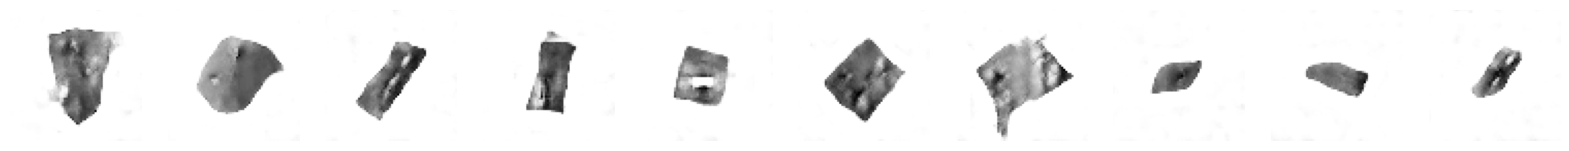

Epoch 62/100
313/313 [==============================] - 51s 163ms/step - d_loss: -0.1781 - d_real_acc: 0.9389 - d_fake_acc: 0.9404 - d_acc: 0.9396 - g_loss: 9.5244 - g_acc: 0.0596
Epoch 63/100
313/313 [==============================] - 51s 163ms/step - d_loss: -0.0695 - d_real_acc: 0.9200 - d_fake_acc: 0.9374 - d_acc: 0.9287 - g_loss: 10.1399 - g_acc: 0.0626
Epoch 64/100
313/313 [==============================] - 51s 161ms/step - d_loss: -0.2389 - d_real_acc: 0.9542 - d_fake_acc: 0.9499 - d_acc: 0.9520 - g_loss: 10.1389 - g_acc: 0.0501
Epoch 65/100
313/313 [==============================] - 51s 162ms/step - d_loss: -0.3586 - d_real_acc: 0.9643 - d_fake_acc: 0.9650 - d_acc: 0.9646 - g_loss: 10.6901 - g_acc: 0.0350
Epoch 66/100
313/313 [==============================] - 51s 162ms/step - d_loss: -0.1408 - d_real_acc: 0.9346 - d_fake_acc: 0.9532 - d_acc: 0.9439 - g_loss: 10.7204 - g_acc: 0.0468
Epoch 67/100
313/313 [==============================] - 50s 158ms/step - d_loss: -0.4485 - d_rea

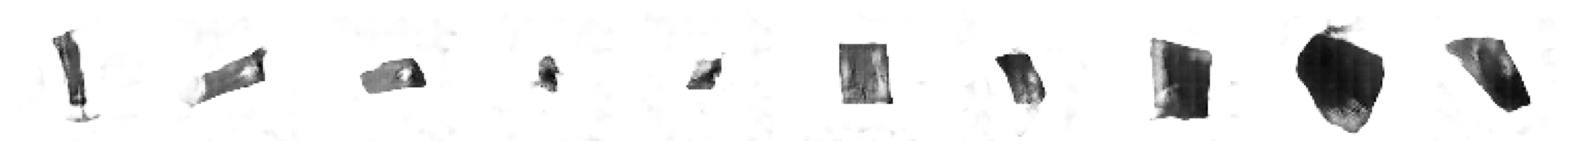

Epoch 72/100
313/313 [==============================] - 48s 154ms/step - d_loss: 6.7224 - d_real_acc: 0.2110 - d_fake_acc: 0.8694 - d_acc: 0.5402 - g_loss: 12.8457 - g_acc: 0.1306
Epoch 73/100
313/313 [==============================] - 50s 159ms/step - d_loss: -0.2535 - d_real_acc: 0.9452 - d_fake_acc: 0.9536 - d_acc: 0.9494 - g_loss: 11.1628 - g_acc: 0.0463
Epoch 74/100
313/313 [==============================] - 50s 159ms/step - d_loss: -0.2609 - d_real_acc: 0.9443 - d_fake_acc: 0.9502 - d_acc: 0.9472 - g_loss: 10.8113 - g_acc: 0.0498
Epoch 75/100
313/313 [==============================] - 50s 159ms/step - d_loss: -0.6162 - d_real_acc: 0.9856 - d_fake_acc: 0.9850 - d_acc: 0.9853 - g_loss: 13.4981 - g_acc: 0.0150
Epoch 76/100
313/313 [==============================] - 50s 159ms/step - d_loss: -0.6691 - d_real_acc: 0.9920 - d_fake_acc: 0.9927 - d_acc: 0.9924 - g_loss: 14.0479 - g_acc: 0.0073
Epoch 77/100
313/313 [==============================] - 50s 160ms/step - d_loss: -0.7685 - d_rea

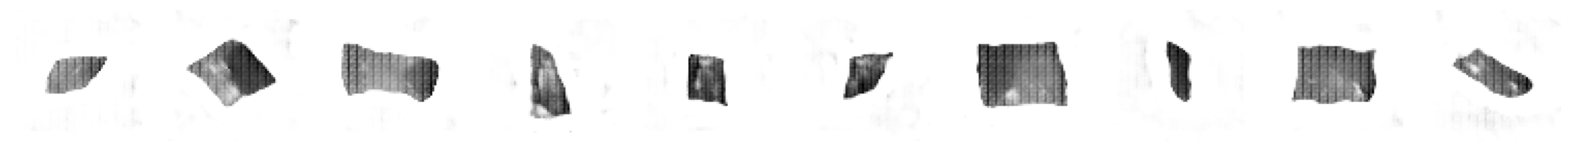

Epoch 82/100
313/313 [==============================] - 48s 153ms/step - d_loss: -0.7676 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4248 - g_acc: 0.0000e+00
Epoch 83/100
313/313 [==============================] - 48s 153ms/step - d_loss: -0.7664 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4248 - g_acc: 0.0000e+00
Epoch 84/100
313/313 [==============================] - 49s 155ms/step - d_loss: -0.7653 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4248 - g_acc: 0.0000e+00
Epoch 85/100
313/313 [==============================] - 48s 153ms/step - d_loss: -0.7667 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4249 - g_acc: 0.0000e+00
Epoch 86/100
313/313 [==============================] - 48s 153ms/step - d_loss: -0.7653 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4247 - g_acc: 0.0000e+00
Epoch 87/100
313/313 [==============================] - 48s 154ms/step - d_

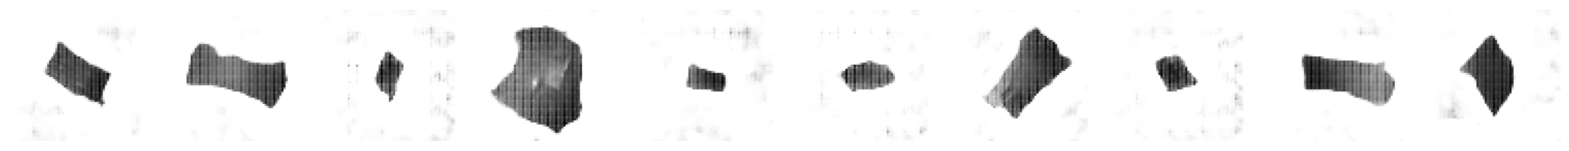

Epoch 92/100
313/313 [==============================] - 50s 158ms/step - d_loss: -0.3163 - d_real_acc: 0.9423 - d_fake_acc: 0.9409 - d_acc: 0.9416 - g_loss: 11.0363 - g_acc: 0.0591
Epoch 93/100
313/313 [==============================] - 50s 159ms/step - d_loss: -0.3481 - d_real_acc: 0.9571 - d_fake_acc: 0.9570 - d_acc: 0.9571 - g_loss: 9.9635 - g_acc: 0.0430
Epoch 94/100
313/313 [==============================] - 50s 159ms/step - d_loss: -0.1730 - d_real_acc: 0.9223 - d_fake_acc: 0.9239 - d_acc: 0.9231 - g_loss: 9.4041 - g_acc: 0.0761
Epoch 95/100
313/313 [==============================] - 50s 158ms/step - d_loss: -0.4397 - d_real_acc: 0.9746 - d_fake_acc: 0.9744 - d_acc: 0.9745 - g_loss: 10.7781 - g_acc: 0.0256
Epoch 96/100
313/313 [==============================] - 77s 245ms/step - d_loss: -0.2428 - d_real_acc: 0.9481 - d_fake_acc: 0.9442 - d_acc: 0.9461 - g_loss: 9.8572 - g_acc: 0.0558
Epoch 97/100
313/313 [==============================] - 90s 287ms/step - d_loss: -0.3871 - d_real_

In [20]:
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [21]:
generator.save("./models/generator")
discriminator.save("./models/discriminator")

INFO:tensorflow:Assets written to: ./models/generator\assets
INFO:tensorflow:Assets written to: ./models/discriminator\assets


In [22]:
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [23]:
reconstructions = generator.predict(z_sample)

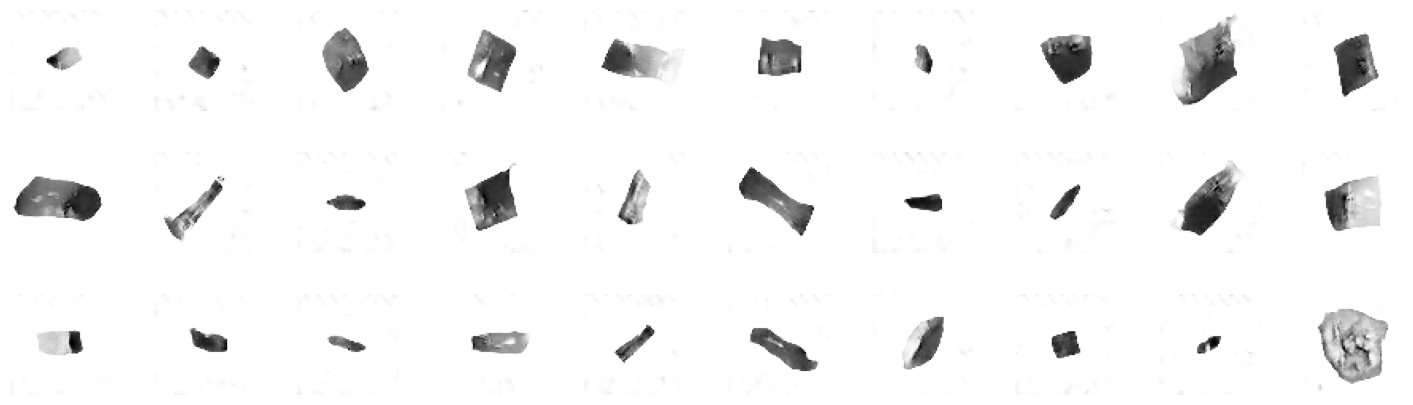

In [24]:
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [25]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [26]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

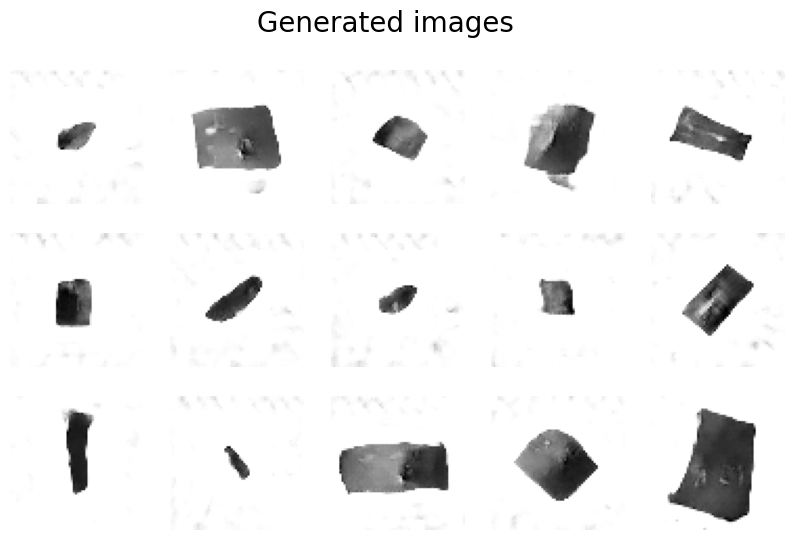

In [27]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

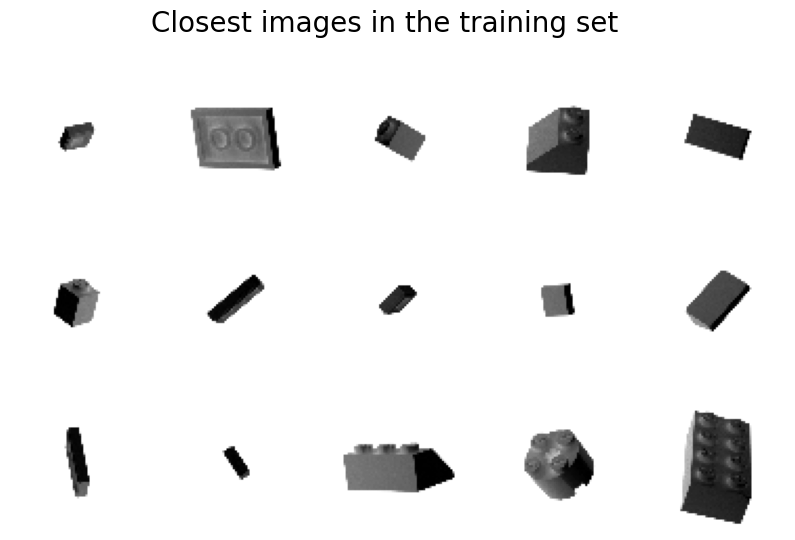

In [28]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()